# Analyzing the Length of "Risk Factors" (Item 1A) in 10-K Filings with FinFeedAPI

## Introduction

Item 1A ("Risk Factors") in Form 10-K annual reports provides crucial insights into the challenges and uncertainties companies face. Analyzing the *length* of this section over time can be a simple quantitative proxy for the perceived complexity or number of risks being disclosed. Increases in length might correlate with periods of higher uncertainty or regulatory changes.

This notebook demonstrates how to:
1.  **Fetch 10-K Filings:** Retrieve metadata for 10-K filings over several years using `/v1/filings`.
2.  **Extract Item 1A Content:** For each 10-K, use `/v1/extractor/item` to get the text content of the "Risk Factors" section.
3.  **Calculate Length:** Measure the length of the extracted content (e.g., number of words or characters).
4.  **Analyze Length Trends:** Analyze how the average or median length of Item 1A changes over the years.

**Note:** This analysis requires fetching the content of a specific item for potentially many filings, which can be API-intensive depending on the number of years and companies analyzed.

## Environment Setup

In [1]:
pip install api-bricks-sec-api-rest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.9 MB/s eta 0:00:00


In [11]:
# Import necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
import os
from IPython.display import display
import time # For delays
import re # For word counting
import api_bricks_sec_api_rest

# --- API Configuration ---
API_KEY = "YOUR_API_KEY_HERE"  # <--- REPLACE THIS WITH YOUR ACTUAL KEY!
api_client = api_bricks_sec_api_rest.ApiClient(header_name="Authorization", header_value=API_KEY)

# --- Analysis Parameters ---
# Years to analyze
START_YEAR = 2018
END_YEAR = 2023 # Adjust as needed

# Item number for Risk Factors (common variations)
RISK_FACTOR_ITEM_IDS = ["1A", "Item 1A"] # Will try these in order

# Max filings per year to analyze (to limit API calls in this demo)
MAX_FILINGS_PER_YEAR = 20 # Set to None for no limit (caution!)

# Delay between extractor calls (seconds)
API_DELAY = 0.3

# --- Plotting Configuration ---
try: plt.style.use('seaborn-v0_8-darkgrid')
except OSError: print("Seaborn style not found, using default."); plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 7)

## 1. Fetching 10-K Filings Metadata

First, we get the list of 10-K filings for each year in our range.

In [12]:
from api_bricks_sec_api_rest.rest import ApiException

api_instance = api_bricks_sec_api_rest.FilingMetadataApi(api_client)
all_10k_metadata = []

for year in range(START_YEAR, END_YEAR + 1):
    print(f"\nFetching 10-K metadata for year: {year}")
    year_start = f"{year}-01-01"
    # Fetch filings filed up to early next year to catch fiscal years ending late in 'year'
    year_end = f"{year+1}-12-30" # e.g., for 2022, fetch until 2023-03-31

    current_page = 1
    filings_this_year = []
    page_size = 200 # Max allowed

    while True:
        # Break if we hit the MAX_FILINGS_PER_YEAR limit for the demo
        if MAX_FILINGS_PER_YEAR and len(filings_this_year) >= MAX_FILINGS_PER_YEAR:
            print(f"  Reached limit of {MAX_FILINGS_PER_YEAR} filings for year {year}.")
            break

        try:
          page_data = api_instance.v1_filings_get (
              form_type = "10-K",
              filling_date_start = year_start,
              filling_date_end = year_end,
              page_size = page_size,
              page_number= current_page
          )
          if page_data is not None and isinstance(page_data, list) and len(page_data) > 0:
              # Add fetched data, respecting the MAX_FILINGS_PER_YEAR limit
              needed = (MAX_FILINGS_PER_YEAR - len(filings_this_year)) if MAX_FILINGS_PER_YEAR else len(page_data)
              filings_to_add = page_data[:needed]
              filings_this_year.extend(filings_to_add)
              print(f"  Fetched page {current_page}, {len(page_data)} records. Added {len(filings_to_add)}. Total for {year}: {len(filings_this_year)}")

              if len(page_data) < page_size: print("  Last page reached for this period."); break
              current_page += 1
          else:
              if page_data == []: print(f"  No more data found on page {current_page}.")
              else: print(f"  API error or unexpected response on page {current_page}. Stopping fetch for {year}.")
              break
          # time.sleep(API_DELAY / 2) # Small delay even between metadata pages
        except ApiException as e:
            print("Exception when calling FilingMetadataApi->v1_filings_get: %s\n" % e)

    all_10k_metadata.extend(filings_this_year)
    print(f"Finished fetching for {year}. Total metadata records so far: {len(all_10k_metadata)}")

# Create DataFrame from metadata
if all_10k_metadata:
    metadata_df = pd.DataFrame.from_records([vars(x) for x in all_10k_metadata])
    metadata_df['filing_date'] = pd.to_datetime(metadata_df['filing_date'], errors='coerce')
    # Add a 'year' column based on filing date for easier grouping
    metadata_df['year'] = metadata_df['filing_date'].dt.year
    print(f"\nTotal 10-K metadata records fetched: {len(metadata_df)}")
    display(metadata_df[['year', 'filing_date', 'cik', 'accession_number']].head())
else:
    print("\nNo 10-K metadata found for the specified years/criteria.")
    metadata_df = pd.DataFrame()


Fetching 10-K metadata for year: 2018
  Fetched page 1, 200 records. Added 20. Total for 2018: 20
  Reached limit of 20 filings for year 2018.
Finished fetching for 2018. Total metadata records so far: 20

Fetching 10-K metadata for year: 2019
  Fetched page 1, 200 records. Added 20. Total for 2019: 20
  Reached limit of 20 filings for year 2019.
Finished fetching for 2019. Total metadata records so far: 40

Fetching 10-K metadata for year: 2020
  Fetched page 1, 200 records. Added 20. Total for 2020: 20
  Reached limit of 20 filings for year 2020.
Finished fetching for 2020. Total metadata records so far: 60

Fetching 10-K metadata for year: 2021
  Fetched page 1, 200 records. Added 20. Total for 2021: 20
  Reached limit of 20 filings for year 2021.
Finished fetching for 2021. Total metadata records so far: 80

Fetching 10-K metadata for year: 2022
  Fetched page 1, 200 records. Added 20. Total for 2022: 20
  Reached limit of 20 filings for year 2022.
Finished fetching for 2022. Tota

,year,filing_date,cik,accession_number
0,2018,2018-07-11,1750,0001047469-18-004978
1,2019,2019-07-18,1750,0001047469-19-004266
2,2018,2018-02-16,1800,0001047469-18-000856
3,2019,2019-02-22,1800,0001047469-19-000624
4,2018,2018-04-02,1961,0001264931-18-000031


## 2. Extracting Item 1A Content and Calculating Length

Now, iterate through the fetched 10-K metadata, call `/v1/extractor/item` for each, and calculate the length.

In [13]:
results = [] # Store results: (year, cik, accession_number, length_chars, length_words)

if not metadata_df.empty:
    api_instance = api_bricks_sec_api_rest.ContentExtractionApi(api_client)

    print(f"\nExtracting Item 1A content for {len(metadata_df)} filings...")
    for index, row in metadata_df.iterrows():
        acc_no = row['accession_number']
        cik = row['cik']
        year = row['year']
        print(f"  Processing {acc_no} (Year: {year}, CIK: {cik})...")

        item_content = None
        # Try common identifiers for Item 1A
        for item_id in RISK_FACTOR_ITEM_IDS:
            try:
                content = api_instance.v1_extractor_item_get (
                    accession_number = acc_no,
                    item_number = item_id
                )

                if content is not None: # Check if content was successfully retrieved (could be empty string "")
                    item_content = content
                    print(f"    Found content using item_number='{item_id}'.")
                    break # Stop trying once content is found
                else:
                    print(f"    Item '{item_id}' not found or error fetching.")
                time.sleep(API_DELAY) # Delay between attempts/filings

            except ApiException as e:
                print("Exception when calling ContentExtractionApi->v1_extractor_get: %s\n" % e)

        # Calculate length if content was found
        length_chars = 0
        length_words = 0
        if item_content is not None:
            item_content = item_content.strip() # Remove leading/trailing whitespace
            length_chars = len(item_content)
            # Simple word count using regex to split by whitespace
            length_words = len(re.findall(r'\S+', item_content))
            print(f"    Content Length: {length_chars} chars, {length_words} words.")
        else:
            print(f"    Could not extract Item 1A content for {acc_no}.")

        results.append({
            'year': year,
            'cik': cik,
            'accession_number': acc_no,
            'length_chars': length_chars if item_content is not None else None, # Use None if extraction failed
            'length_words': length_words if item_content is not None else None
        })

    # Create DataFrame from results
    length_df = pd.DataFrame(results)
    print("\nFinished extraction and length calculation.")
    display(length_df.head())
else:
    print("\nMetadata DataFrame is empty. Skipping extraction.")
    length_df = pd.DataFrame()


Extracting Item 1A content for 120 filings...
  Processing 0001047469-18-004978 (Year: 2018, CIK: 1750)...
    Found content using item_number='1A'.
    Content Length: 24844 chars, 3715 words.
  Processing 0001047469-19-004266 (Year: 2019, CIK: 1750)...
    Found content using item_number='1A'.
    Content Length: 29656 chars, 4439 words.
  Processing 0001047469-18-000856 (Year: 2018, CIK: 1800)...
    Found content using item_number='1A'.
    Content Length: 25623 chars, 3654 words.
  Processing 0001047469-19-000624 (Year: 2019, CIK: 1800)...
    Found content using item_number='1A'.
    Content Length: 26334 chars, 3741 words.
  Processing 0001264931-18-000031 (Year: 2018, CIK: 1961)...
    Found content using item_number='1A'.
    Content Length: 11505 chars, 1824 words.
  Processing 0001264931-19-000040 (Year: 2019, CIK: 1961)...
    Found content using item_number='1A'.
    Content Length: 10713 chars, 1697 words.
  Processing 0001144204-18-051414 (Year: 2018, CIK: 2034)...
    

,year,cik,accession_number,length_chars,length_words
0,2018,1750,0001047469-18-004978,24844.0,3715.0
1,2019,1750,0001047469-19-004266,29656.0,4439.0
2,2018,1800,0001047469-18-000856,25623.0,3654.0
3,2019,1800,0001047469-19-000624,26334.0,3741.0
4,2018,1961,0001264931-18-000031,11505.0,1824.0


## 3. Analyzing Length Trends Over Time

Calculate and plot the average or median length of Item 1A per year. Median is often more robust to outliers (very long or short sections).


Analyzing length trends based on 116 filings with successful Item 1A extraction.


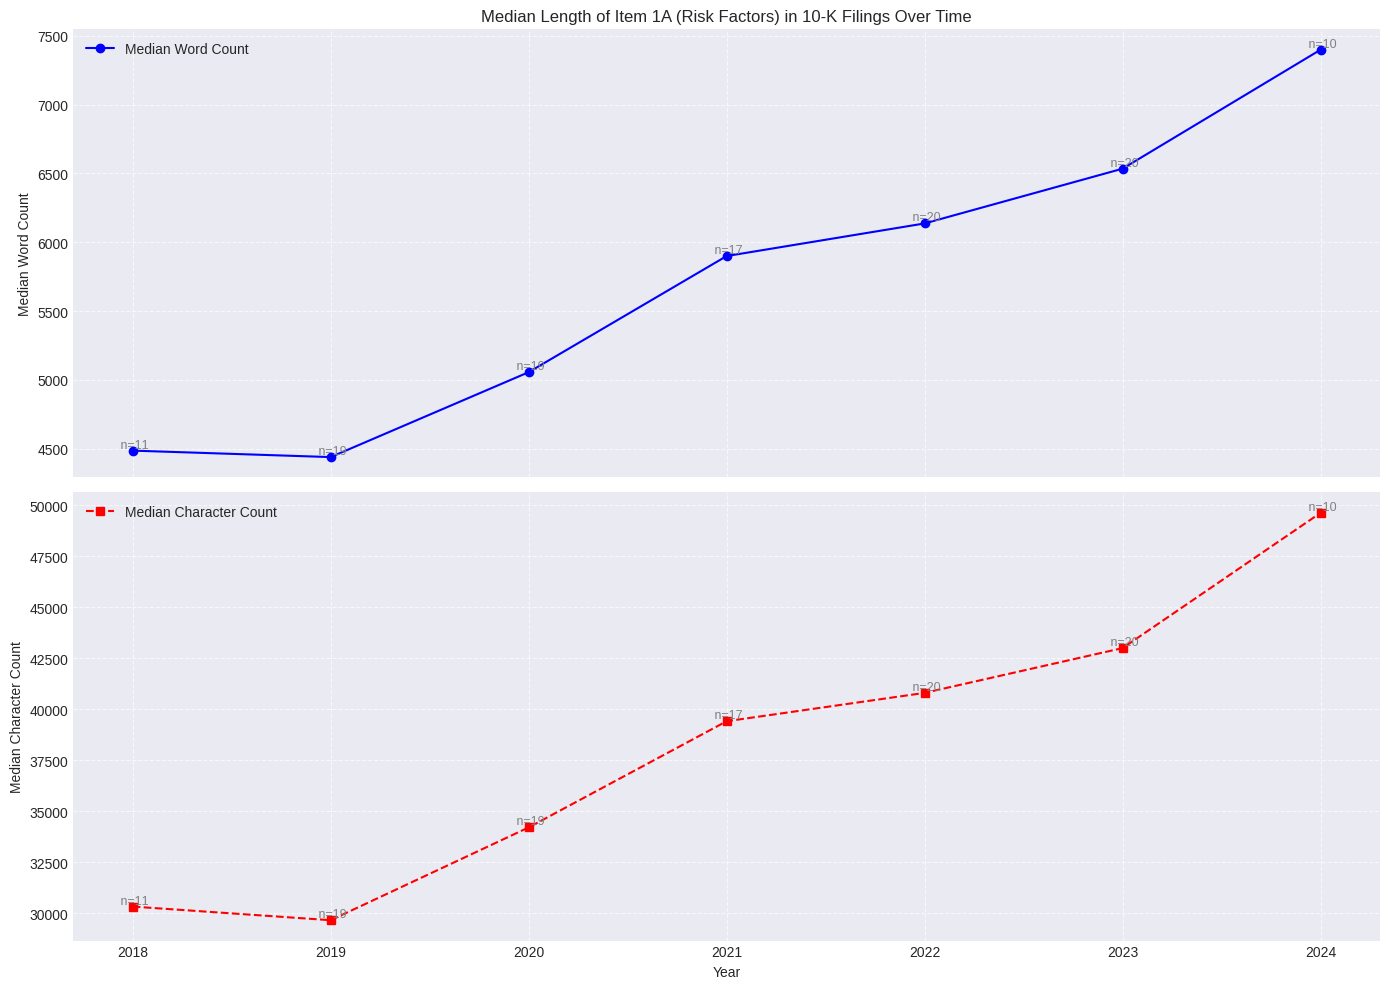


Median Length Data:


,Median Words,Median Chars,Filings Analyzed
year,,,
2018,4486.0,30325.0,11
2019,4439.0,29656.0,19
2020,5056.0,34206.0,19
2021,5900.0,39413.0,17
2022,6137.0,40803.5,20
2023,6535.0,42999.5,20
2024,7399.5,49632.0,10


In [14]:
if not length_df.empty:
    # Drop rows where length calculation failed
    length_df_cleaned = length_df.dropna(subset=['length_words', 'length_chars'])

    if not length_df_cleaned.empty:
        print(f"\nAnalyzing length trends based on {len(length_df_cleaned)} filings with successful Item 1A extraction.")

        # Calculate median length per year
        median_length_words = length_df_cleaned.groupby('year')['length_words'].median()
        median_length_chars = length_df_cleaned.groupby('year')['length_chars'].median()
        count_per_year = length_df_cleaned.groupby('year').size()

        # Create plots
        fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

        # Plot Median Word Count
        axes[0].plot(median_length_words.index, median_length_words.values, marker='o', linestyle='-', color='blue', label='Median Word Count')
        axes[0].set_title('Median Length of Item 1A (Risk Factors) in 10-K Filings Over Time')
        axes[0].set_ylabel('Median Word Count')
        axes[0].grid(True, linestyle='--', alpha=0.7)
        axes[0].legend()
        # Add count annotations
        for year, count in count_per_year.items():
             if year in median_length_words.index:
                  axes[0].text(year, median_length_words[year], f' n={count}', verticalalignment='bottom', horizontalalignment='center', fontsize=9, color='gray')


        # Plot Median Character Count
        axes[1].plot(median_length_chars.index, median_length_chars.values, marker='s', linestyle='--', color='red', label='Median Character Count')
        axes[1].set_xlabel('Year')
        axes[1].set_ylabel('Median Character Count')
        axes[1].grid(True, linestyle='--', alpha=0.7)
        axes[1].legend()
        # Add count annotations
        for year, count in count_per_year.items():
            if year in median_length_chars.index:
                axes[1].text(year, median_length_chars[year], f' n={count}', verticalalignment='bottom', horizontalalignment='center', fontsize=9, color='gray')


        plt.xticks(median_length_words.index.astype(int)) # Ensure integer years on x-axis
        plt.tight_layout()
        plt.show()

        print("\nMedian Length Data:")
        display(pd.DataFrame({'Median Words': median_length_words, 'Median Chars': median_length_chars, 'Filings Analyzed': count_per_year}))

    else:
        print("No valid length data available after cleaning.")
else:
    print("Length DataFrame is empty. Skipping trend analysis.")

## Conclusion

This notebook demonstrated a quantitative approach to analyzing the "Risk Factors" section (Item 1A) of Form 10-K filings using the FinFeedAPI. We:
1.  Fetched 10-K metadata over several years.
2.  Used the `/v1/extractor/item` endpoint to retrieve the text content of Item 1A for each filing.
3.  Calculated the character and word count for the extracted text.
4.  Analyzed and visualized the trend of the median length of this section over time.

Changes in the length of the Risk Factors section could potentially indicate shifts in the complexity of the business environment, regulatory landscape, or the company's own risk profile. This type of quantitative analysis can complement qualitative reading of the disclosures.

**Limitations:**
* The analysis relies on the successful extraction of Item 1A, which might fail if the filing structure is unusual or the API cannot identify the item.
* Length is a crude proxy; it doesn't capture the *severity* or *nature* of the risks discussed.
* The analysis is sensitive to the sample of companies included (if `TARGET_CIKS` or `MAX_FILINGS_PER_YEAR` is used).